In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        
        self.scale = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        self.clust_raw = nn.Parameter(torch.zeros(self.sub_no, self.in_no), requires_grad=True)
        
    def forward(self, S, temp, test):
        T_data = S.shape[0]
        
        S = S * self.scale.reshape(1,-1)
        
        if test == False:
            W_clust = F.softmax(self.clust_raw/temp, 0)
        elif test == True:
            W_clust = torch.zeros_like(self.clust_raw).to(self.device)
            for i in range(W_clust.shape[1]):
                idx = torch.argmax(self.clust_raw[:,i])
                W_clust[idx,i] = 1
        
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
        
        final = torch.sum(sub_out, 1)
        
        return final, sub_out, W_clust

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
device = "cuda"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)


In [4]:
V_test = V[-50000:].to(device).float()
test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)


In [5]:
H_no = 20
layer_no = 1
sub_no = 4
in_no = 299
T_no = 501
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")
temp = 0

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h20_spat_v2.pt"))
model.eval()
model.cuda()

GenericGRU(
  (rnn): ModuleList(
    (0): GRU(1, 20, batch_first=True)
    (1): GRU(1, 20, batch_first=True)
    (2): GRU(1, 20, batch_first=True)
    (3): GRU(1, 20, batch_first=True)
  )
  (linear): ModuleList(
    (0): Linear(in_features=20, out_features=1, bias=True)
    (1): Linear(in_features=20, out_features=1, bias=True)
    (2): Linear(in_features=20, out_features=1, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,e_idx], temp, True)

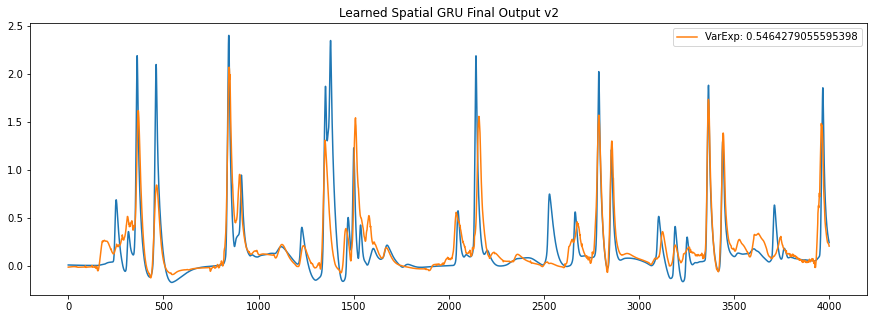

In [8]:
test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())

plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][2000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][2000:6000], label="VarExp: "+str(test_score))
plt.title("Learned Spatial GRU Final Output v2")
plt.legend()

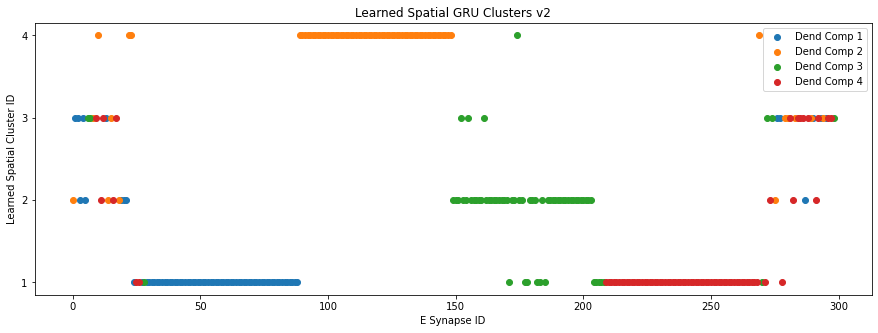

In [9]:
plt.figure(figsize = (15,5))
W_clust_aug = np.zeros((test_W_clust.shape[1], 2))

for i in range(test_W_clust.shape[1]):
    hot_idx = np.where(test_W_clust[:,i].cpu().detach().numpy() == 1)[0]
    W_clust_aug[i,0] = i
    W_clust_aug[i,1] = hot_idx+1

for i in range(den_idx.shape[0]):
    syn_idx = np.where(eloc[e_idx,0] == den_idx[i])[0]
    plt.scatter(W_clust_aug[syn_idx,0], W_clust_aug[syn_idx,1], label="Dend Comp "+str(i+1))

plt.legend()
plt.yticks([1,2,3,4])
plt.xlabel("E Synapse ID")
plt.ylabel("Learned Spatial Cluster ID")
plt.title("Learned Spatial GRU Clusters v2")
plt.show()

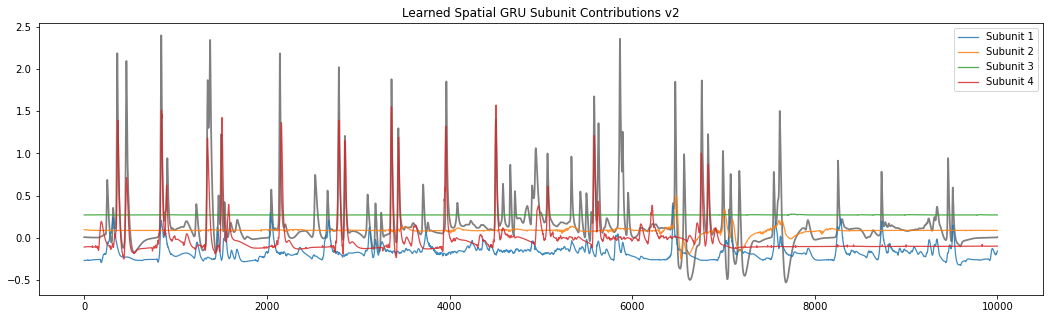

In [10]:
plt.figure(figsize = (18,5))

plt.plot(V_test.cpu().detach().numpy()[18000:28000], c="gray", linewidth=1.75)

for i in range(sub_no):
    plt.plot(test_sub_out[:,i][18000:28000].cpu().detach().numpy(), linewidth=1.25, alpha=0.85, label="Subunit "+str(i+1))

plt.title("Learned Spatial GRU Subunit Contributions v2")
plt.legend()

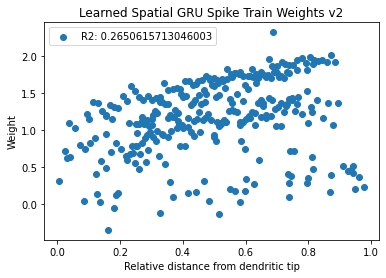

In [11]:
scale= model.scale.cpu().detach().numpy()
den_loc = eloc[e_idx,1]
corr = np.corrcoef(den_loc, scale)[0][1]

plt.scatter(den_loc, scale, label="R2: "+str(corr))
plt.title("Learned Spatial GRU Spike Train Weights v2")
plt.ylabel("Weight")
plt.xlabel("Relative distance from dendritic tip")
plt.legend()

In [24]:
print(test_W_clust[:,:15])


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
       device='cuda:0')


In [27]:

dist_list = [200,100,75,50,40,30,25,20,15,10,5]
full_test_out = np.zeros((len(dist_list), 50000))

for i in tnrange(len(dist_list)):
    test_in = torch.zeros(50000, 299).to(device)
    for j in range(15):
        test_in[5000+j*dist_list[i],10] = 1
    test_out, test_sub, W_clust = model(test_in, temp=0, test=True)
    full_test_out[i] = test_out.cpu().detach().numpy()

<ipython-input-27-77cea223123a>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(dist_list)):


Text(0.5, 0.9, 'Learned Spatial GRU Subunit 2 Temporal Test v2')

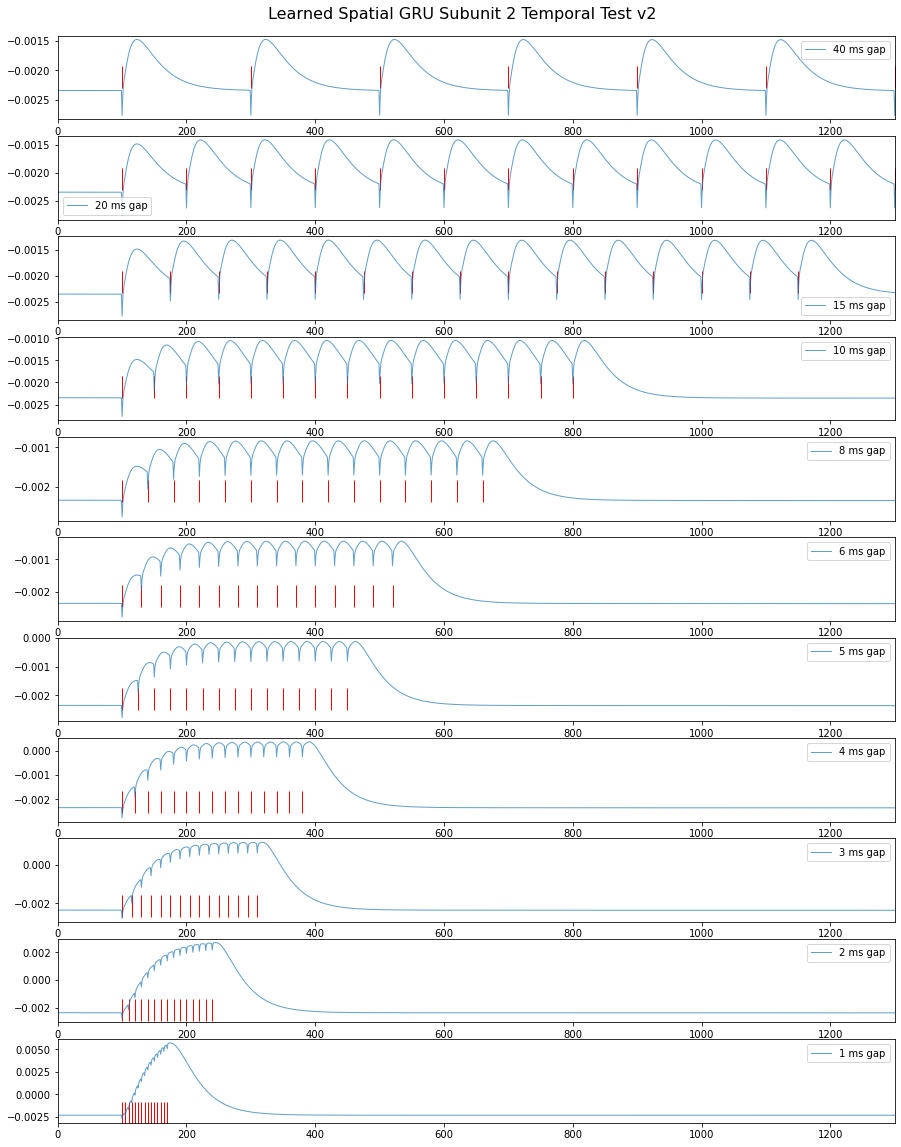

In [28]:
fig, axs = plt.subplots(nrows=len(dist_list), figsize= (15,20))
for i in range(len(dist_list)):
    axs[i].plot(full_test_out[i][4900:8200], label=str(dist_list[i]//5)+" ms gap", alpha=0.7, linewidth=1)
    mean_val = np.mean(full_test_out[i][4900:8200])
    axs[i].scatter(np.arange(100,dist_list[i]*15+100,dist_list[i]), np.ones((15))*mean_val,
                   marker="|", s=500, color="red", linewidth=1)
    axs[i].set_xlim(0,1300)
    axs[i].legend()
    
fig.suptitle("Learned Spatial GRU Subunit 2 Temporal Test v2", y=0.9, fontsize=16)